# **Practica Optimización Bayesiana**

## **Cancer de Prostata**

---

El taller busca desarrollar el mejor modelo predictivo que permita estimar la probabilidad de que un usuario entre 48 y 60 años de edad presente resultados anormales de PSA.

In [1]:
!pip install bayesian-optimization
!pip install imbalanced-learn

You should consider upgrading via the 'C:\Users\1130590314\OneDrive - Universidad Icesi\Proyectos\Dengue\Pruebas1\Scripts\python3.exe -m pip install --upgrade pip' command.


     -------------------------------------- 258.3/258.3 KB 5.3 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\1130590314\OneDrive - Universidad Icesi\Proyectos\Dengue\Pruebas1\Scripts\python3.exe -m pip install --upgrade pip' command.


In [2]:


import pickle
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, mstats
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel  # para seleccionar los coeficientes de lasso
from sklearn.metrics import roc_auc_score
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
set_config(display="diagram")

from sklearn.neural_network import MLPClassifier
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from xgboost import XGBClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

#***Funciones***

In [3]:
def get_original_feature(col_name):
    for orig_col in var_categoricas:
        if col_name.startswith(orig_col):
            return orig_col
    return col_name

Este código calcula y visualiza la cantidad y el porcentaje de valores nulos en cada columna del df. Además, permite identificar aquellas columnas cuyo porcentaje de nulos supera un umbral definido.

In [4]:
def calcular_porcentaje_nulos_con_umbral(df, umbral=0.7):
    # Crear un DataFrame con la cantidad de nulos
    nulos = df.isnull().sum()

    # Calcular el porcentaje de nulos
    porcentaje_nulos = (nulos / len(df)) * 100

    # Crear un nuevo DataFrame con el nombre de la columna, cantidad de nulos y porcentaje de nulidad
    df_nulos = pd.DataFrame({
        'Columna': nulos.index,
        'Cantidad de Nulos': nulos.values,
        'Porcentaje de Nulos (%)': porcentaje_nulos.values
    })

    # Ordenar de mayor a menor por porcentaje de nulidad
    df_nulos = df_nulos.sort_values(by='Porcentaje de Nulos (%)', ascending=False).reset_index(drop=True)

    # Filtrar las columnas que exceden el umbral
    variables_muy_nulas = df_nulos[df_nulos['Porcentaje de Nulos (%)'] > (umbral * 100)]['Columna'].tolist()

    return df_nulos, variables_muy_nulas


#***EDA***
En este análisis exploratorio de datos, exploraremos, transformaremos y evaluaremos nuestras variables para asegurar que solo las más relevantes sean utilizadas en nuestro modelo predictivo. Aplicaremos técnicas para categorizar, manejar valores nulos, y evaluar la importancia de cada variable con respecto a la variable objetivo, Target.

##**Cargue y reconocimiento del DataSet**

In [6]:
df = pd.read_parquet("./df_train.parquet")
print(df.shape)
df.head()

(23494, 46)


,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
16484,12.0,3.0,3.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,58373.057143,-110021.200000,1.885690e+05
11528,6.0,1.0,1.0,2,0.5,NaN,0.0,NaN,NaN,1.0,...,0,0,0,0,0,0,0,19618.942857,-36176.133333,9.747050e+04
26630,1.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,1,398534.000000,-626628.000000,2.304723e+06
12586,6.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,1292.600000,13410.733333,5.380450e+04
11225,3.0,0.0,2.0,1,1.0,NaN,0.0,NaN,NaN,1.0,...,2,2,2,2,2,2,0,13728.714286,-27375.666667,4.134967e+04


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23494 entries, 16484 to 9409
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   23494 non-null  float64
 1   MEDICINA ESPECIALIZADA         23494 non-null  float64
 2   MEDICINA GENERAL               23494 non-null  float64
 3   Cant_gr_flia                   23494 non-null  int64  
 4   Cant_riesgos_flia_mean         23494 non-null  float64
 5   min_Tiempo_CP_Fliar            8 non-null      float64
 6   Cant_Fliar_CP                  23494 non-null  float64
 7   psa_max_gr_flia                164 non-null    float64
 8   psa_min_gr_flia                164 non-null    float64
 9   Cant_Fliar_riesgos             23494 non-null  float64
 10  cantidad_serv_flia             23494 non-null  float64
 11  Pendiente_flia                 23494 non-null  float64
 12  Intercepto_flia                23494 non-null  f

##**Baseline**


In [8]:
class_percentages = df['Target'].value_counts(normalize=True) * 100
print(class_percentages)

Target
0    71.537414
1    28.462586
Name: proportion, dtype: float64


De esta manera el baseline es la clase mayoritoira, que viene siendo 71.5%. Nuestro modelo de clasificación se espera que sea mucho mejor.

##**Manejo de Valores Nulos**
Observaremos la cantidad porcentual de nulos por cada variable. Aquellas que superen un umbral predefinido serán desestimadas del análisis, ya que una alta proporción de valores faltantes puede generar sesgos y reducir la calidad de nuestros modelos predictivos.

In [9]:
# Usar la función con un umbral de 0.7 (70%) para ver cantidad de nulos por columna
df_resultado, variables_muy_nulas = calcular_porcentaje_nulos_con_umbral(df, umbral=0.7)
df_resultado

,Columna,Cantidad de Nulos,Porcentaje de Nulos (%)
0,min_Tiempo_CP_Fliar,23486,99.965949
1,psa_max_gr_flia,23330,99.301949
2,psa_min_gr_flia,23330,99.301949
3,PERDIDA_DE_PESO,17723,75.436282
4,RIESGOS,16283,69.307057
5,IMC,10364,44.113391
6,CANCER_MAMA_FAMILIAR,6802,28.952073
7,AGRUPACION_DIASTOLICA,3320,14.131268
8,AGRUPACION_SISTOLICA,3320,14.131268
9,DIABETES_FAMILIAR,0,0.000000


In [10]:
variables_muy_nulas

['min_Tiempo_CP_Fliar',
 'psa_max_gr_flia',
 'psa_min_gr_flia',
 'PERDIDA_DE_PESO']

In [11]:
df = df.drop(columns=variables_muy_nulas)
df.head()

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,Cant_Fliar_CP,Cant_Fliar_riesgos,cantidad_serv_flia,Pendiente_flia,Intercepto_flia,...,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
16484,12.0,3.0,3.0,2,0.0,0.0,0.0,34.0,15998.485714,-23363.200000,...,0,0,0,0,0,0,0,58373.057143,-110021.200000,1.885690e+05
11528,6.0,1.0,1.0,2,0.5,0.0,1.0,25.0,655.200000,-1019.200000,...,0,0,0,0,0,0,0,19618.942857,-36176.133333,9.747050e+04
26630,1.0,0.0,2.0,2,0.0,0.0,0.0,36.0,342236.971429,-521835.400000,...,0,0,0,0,0,0,1,398534.000000,-626628.000000,2.304723e+06
12586,6.0,0.0,2.0,2,0.0,0.0,0.0,24.0,-4468.285714,30687.333333,...,0,0,0,0,0,0,0,1292.600000,13410.733333,5.380450e+04
11225,3.0,0.0,2.0,1,1.0,0.0,1.0,7.0,0.000000,0.000000,...,2,2,2,2,2,2,0,13728.714286,-27375.666667,4.134967e+04


##**Categorización de Variables con Pocos Valores Únicos**
Identificaremos las variables que tienen menos de 8 valores únicos y las convertiremos en variables categóricas. Este proceso ayudará a manejar estas variables de manera adecuada en modelos de aprendizaje automático, asegurando que sean tratadas como categorías discretas.

In [12]:
# Mostrar la cantidad de valores únicos por columna
unique_values = df.nunique()
print("Cantidad de valores únicos por columna:")
print(unique_values)

# Convertir las columnas con menos de 10 valores únicos en variables categóricas (como object)
for col in df.columns:
    if col != 'Target':  # No cambiar el tipo de la columna 'Target'
        if df[col].nunique() < 8:
            df[col] = df[col].astype('object')  # Cambiar a 'object' para variables categóricas
        else:
            df[col] = df[col].astype('float64')  # Cambiar a tipo numérico si es necesario

# Verificar la conversión
print("\nTipos de datos actualizados:")
print(df.dtypes)

Cantidad de valores únicos por columna:
MEDICAMENTOS                        82
MEDICINA ESPECIALIZADA              39
MEDICINA GENERAL                    20
Cant_gr_flia                        10
Cant_riesgos_flia_mean              32
Cant_Fliar_CP                        2
Cant_Fliar_riesgos                   3
cantidad_serv_flia                 233
Pendiente_flia                   15471
Intercepto_flia                  15515
Promedio_costo_flia              14325
ESTADO_CIVI                          6
PROGRAMA                             3
estrato                              5
IMC                                  4
AGRUPACION_SISTOLICA                 3
AGRUPACION_DIASTOLICA                3
parentesco                           7
EDAD                                12
RIESGOS                              8
CANTIDAD_SERVICIOS                 123
TIEMPO_ULTIMA_CITA                   7
conteo_dx_diferentes                23
TIEMPO_AFILIACION                  343
CANCER_MAMA_FAMILIAR    

##**Importancia de Variables Categóricas respecto a Target**
Utilizaremos técnicas de análisis de importancia para determinar el valor predictivo de cada variable categórica respecto a Target. Solo conservaremos aquellas cuya importancia supere un umbral de 0.045, lo que garantizará que el modelo utilice solo las características categóricas más relevantes.

In [13]:
X, y = df.drop(columns="Target"), df["Target"]
y.value_counts(True) * 100

Target
0    71.537414
1    28.462586
Name: proportion, dtype: float64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
var_numericas = X_train.select_dtypes(include=['int64', 'float64']).columns
var_categoricas = X_train.select_dtypes('object').columns
var_categoricas

Index(['Cant_Fliar_CP', 'Cant_Fliar_riesgos', 'ESTADO_CIVI', 'PROGRAMA',
       'estrato', 'IMC', 'AGRUPACION_SISTOLICA', 'AGRUPACION_DIASTOLICA',
       'parentesco', 'TIEMPO_ULTIMA_CITA', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'HIPERTENSION',
       'HIPERTENSION_FAMILIAR', 'DIABETES', 'DIABETES_FAMILIAR', 'CORONARIOS',
       'CORONARIOS_FAMILIAR', 'CEREBRAL', 'CEREBRAL_FAMILIAR',
       'ENFERMEDAD_RENAL', 'ENFERMEDAD_RENAL_FAMILIAR',
       'OTROS_ANTECEDENTES_VASCULARES'],
      dtype='object')

#***Custom transformers***

In [17]:
class ReplaceNulosConCategoria(BaseEstimator, TransformerMixin):
    def __init__(self, columna, nueva_categoria="2"):
        self.columna = columna
        self.nueva_categoria = nueva_categoria

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.columna] = X[self.columna].fillna(self.nueva_categoria)
        return X

In [18]:
class ReplaceNulosConCero(BaseEstimator, TransformerMixin):
    def __init__(self, columna):
        self.columna = columna

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.columna] = X[self.columna].fillna(0)
        return X

En este proyecto, se desarrollaron dos **transformadores personalizados** para manejar imputaciones específicas en dos columnas donde no era adecuado usar las técnicas convencionales de imputación:

1. **ReplaceNulosConCero**:
   - Este transformador fue diseñado para la columna **"RIESGOS"**, la cual contenía valores nulos que indicaban la ausencia de riesgos identificados. Dado que los valores nulos en esta columna no debían interpretarse como datos faltantes sino como la ausencia de riesgo, se decidió reemplazar estos nulos con el valor **0**, indicando explícitamente la falta de riesgos.

2. **ReplaceNulosConCategoria**:
   - Este transformador fue creado para la columna **"CANCER_MAMA_FAMILIAR"**, en la que los valores nulos no debían ser imputados de forma tradicional, debido a su naturaleza en el contexto del negocio. En lugar de hacer una imputación numérica o estadística, se creó una nueva categoría llamada **"2"**, que hace referencia a **"no identificado"**. Este enfoque permitía mantener los datos consistentes y reflejar adecuadamente la falta de información en este campo.

---

Estos transformadores personalizados fueron clave para preservar la integridad semántica de los datos durante el preprocesamiento, ajustándose a las necesidades del dominio específico de negocio.

In [19]:
categorical_transformer = Pipeline(steps=[
    ('reemplazar_nulos_categoricos', ReplaceNulosConCategoria(columna='CANCER_MAMA_FAMILIAR', nueva_categoria="2")),
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Crear un ColumnTransformer para aplicar solo a las variables categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, var_categoricas)
    ])

# Crear un pipeline completo con el preprocesamiento y el modelo RandomForest
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Entrenar el pipeline con los datos
model_pipeline.fit(X_train, y_train)

# Ahora puedes obtener la importancia de las características de las variables categóricas
# Necesitamos extraer el modelo RandomForest después de entrenar
rf_model = model_pipeline.named_steps['classifier']

# Extraer las columnas transformadas por el OneHotEncoder
encoded_col_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(var_categoricas)

# Obtener la importancia de las variables categóricas codificadas
importances = rf_model.feature_importances_

# Crear un DataFrame con las importancias y los nombres de las variables codificadas
importance_df = pd.DataFrame({'feature': encoded_col_names, 'importance': importances})


In [20]:
# Revisar valores nulos antes del pipeline
print("Valores nulos iniciales en variables categóricas:")
print(X_train[var_categoricas].isnull().sum())

# Aplicar solo el paso del imputador para verificar si está funcionando correctamente
imputed_data = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['imputer'].fit_transform(X_train[var_categoricas])

# Verificar si quedan valores nulos después del imputador
print("Valores nulos después de la imputación:")
print(pd.DataFrame(imputed_data, columns=var_categoricas).isnull().sum())


Valores nulos iniciales en variables categóricas:
Cant_Fliar_CP                       0
Cant_Fliar_riesgos                  0
ESTADO_CIVI                         0
PROGRAMA                            0
estrato                             0
IMC                              8269
AGRUPACION_SISTOLICA             2674
AGRUPACION_DIASTOLICA            2674
parentesco                          0
TIEMPO_ULTIMA_CITA                  0
CANCER_MAMA_FAMILIAR             5419
CANCER_OTRO_SITIO                   0
CANCER_OTRO_SITIO_FAMILIAR          0
HIPERTENSION                        0
HIPERTENSION_FAMILIAR               0
DIABETES                            0
DIABETES_FAMILIAR                   0
CORONARIOS                          0
CORONARIOS_FAMILIAR                 0
CEREBRAL                            0
CEREBRAL_FAMILIAR                   0
ENFERMEDAD_RENAL                    0
ENFERMEDAD_RENAL_FAMILIAR           0
OTROS_ANTECEDENTES_VASCULARES       0
dtype: int64
Valores nulos después de 

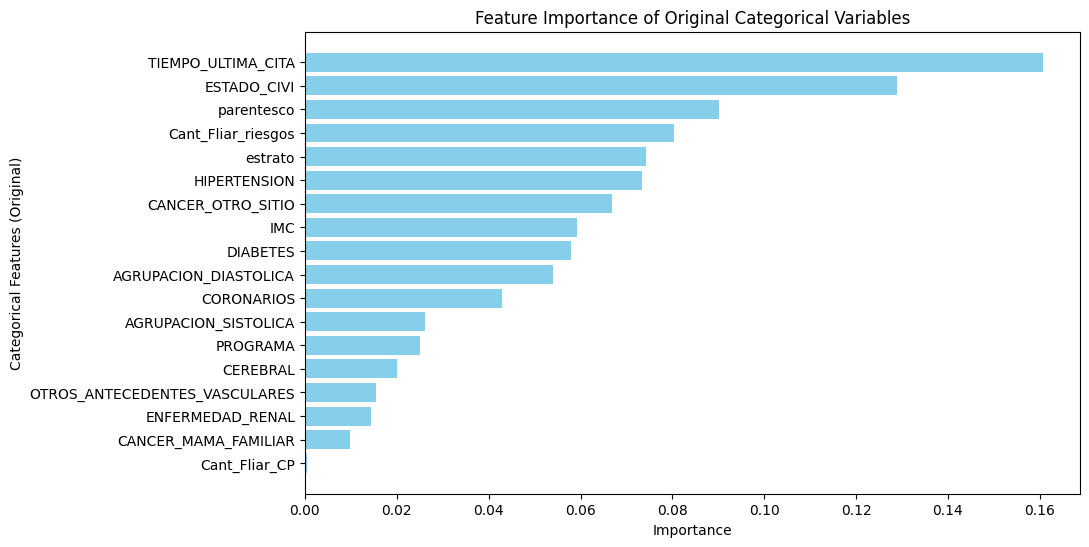

In [21]:
# Obtener la columna original de cada columna codificada
importance_df['original_feature'] = importance_df['feature'].apply(get_original_feature)

# Agrupar por las variables categóricas originales y sumar las importancias de las columnas codificadas
importance_by_category = importance_df.groupby('original_feature')['importance'].sum()
importance_by_category = importance_by_category.sort_values(ascending=False)

# Mostrar la importancia de las variables categóricas originales
plt.figure(figsize=(10, 6))
plt.barh(importance_by_category.index, importance_by_category.values, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Categorical Features (Original)')
plt.title('Feature Importance of Original Categorical Variables')
plt.gca().invert_yaxis()
plt.show()

In [22]:
importance_by_category = importance_by_category[importance_by_category > 0.045]
importance_by_category.index

Index(['TIEMPO_ULTIMA_CITA', 'ESTADO_CIVI', 'parentesco', 'Cant_Fliar_riesgos',
       'estrato', 'HIPERTENSION', 'CANCER_OTRO_SITIO', 'IMC', 'DIABETES',
       'AGRUPACION_DIASTOLICA'],
      dtype='object', name='original_feature')

##**Importancia de Variables Numéricas respecto a Target**


###**Distribución de Variables Cuantitativas Respecto a Target**
Examinaremos cómo se distribuyen nuestras variables cuantitativas en función de la variable objetivo Target. Esto nos permitirá entender la relación entre las características numéricas y la variable de interés, proporcionando pistas sobre patrones o tendencias relevantes para el modelado.

Text(0.5, 0.98, 'Distribución de densidad de variables numéricas por clase (0 y 1)')

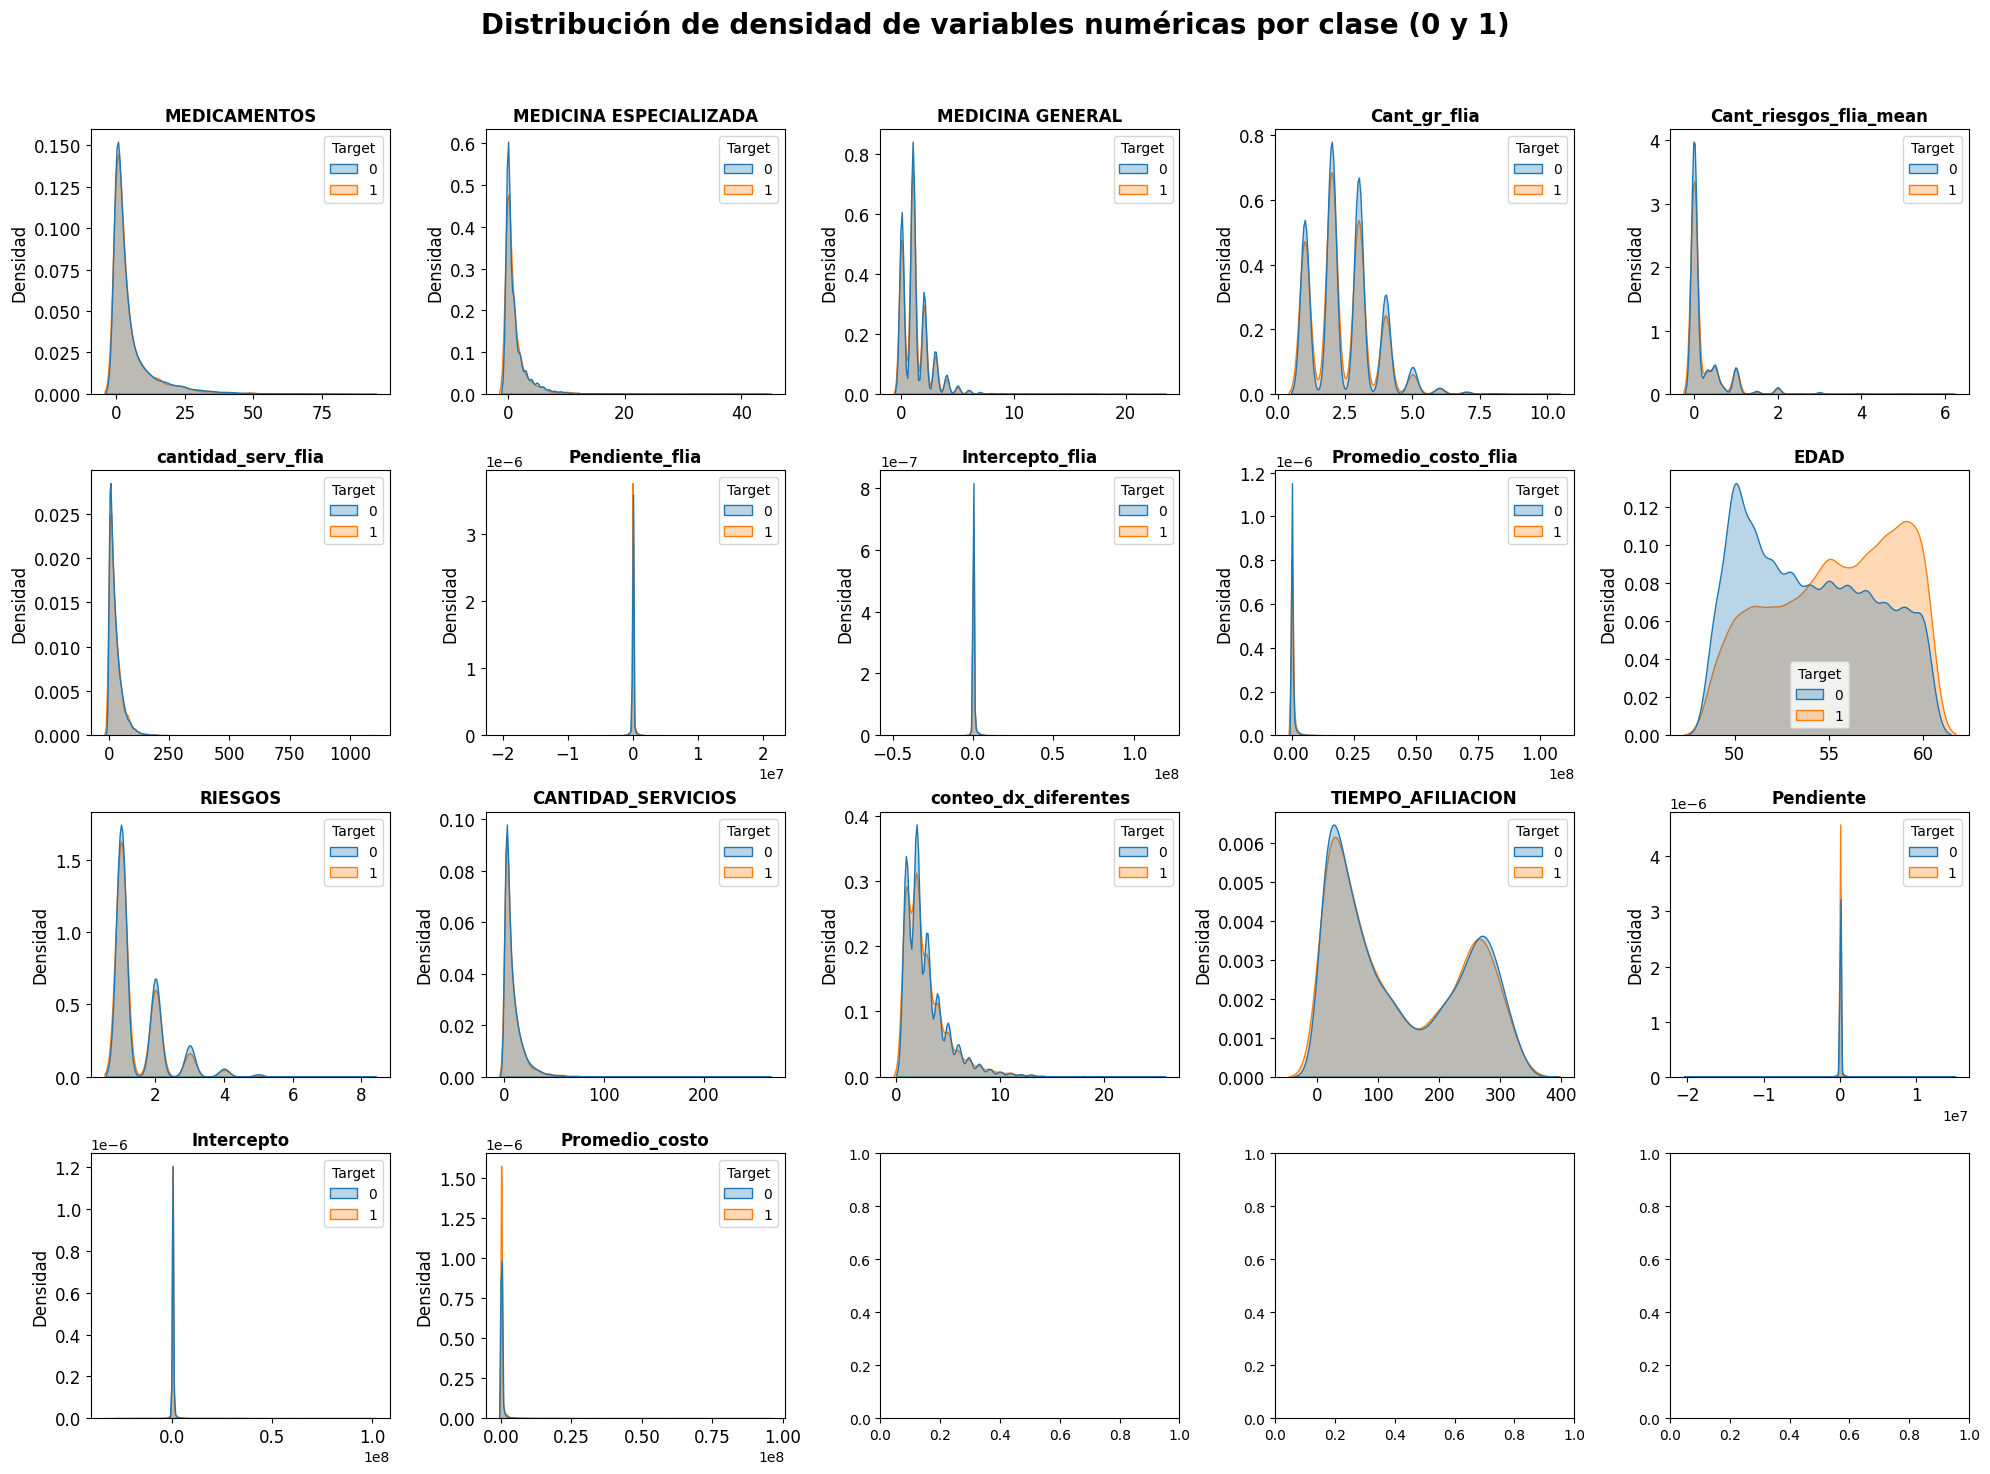

In [23]:
# Gráfico de distribución de densidad para cada variable numérica, desglosado por la clase de la variable objetivo
# ==============================================================================

# Ajustar número de subplots en función del número de columnas numéricas
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 15))  # Ajustar las dimensiones según el número de columnas
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('Target')  # dropping the Target column as it is not numeric

# Recorrer las columnas numéricas y generar un gráfico de densidad para cada una, separando por la clase target
for i, colum in enumerate(columnas_numeric):
    sns.kdeplot(
        data=df,  # Conjunto de datos
        x=colum,
        hue='Target',  # Desglosar por la columna de clase target (0 y 1)
        fill=True,  # Rellenar debajo de la curva
        common_norm=False,  # Mantener las distribuciones independientes por clase
        alpha=0.3,
        ax=axes[i]
    )
    axes[i].set_title(colum, fontsize=12, fontweight="bold")
    axes[i].tick_params(labelsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Densidad", fontsize=12)

# Ajustar el layout para evitar solapamiento
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución de densidad de variables numéricas por clase (0 y 1)', fontsize=20, fontweight="bold")

#### **Evaluación de Diferencias Significativas entre Clases de Target**

Evaluaremos cuáles variables muestran diferencias significativas entre las clases de Target. Esto nos permitirá priorizar aquellas variables que mejor diferencian entre las clases, lo que será clave para mejorar la precisión del modelo.

In [24]:
# Crear un DataFrame para almacenar los resultados de las pruebas
resultados_ks = pd.DataFrame(columns=['variable', 'p_value'])

# Recorrer las columnas numéricas y aplicar la prueba KS
for col in columnas_numeric:
    # Separar los datos por clase
    clase_0 = df[df['Target'] == 0][col]
    clase_1 = df[df['Target'] == 1][col]

    # Aplicar la Prueba de Kolmogorov-Smirnov
    stat, p_value = ks_2samp(clase_0, clase_1)

    # Almacenar los resultados en el DataFrame
    resultados_ks = pd.concat([resultados_ks, pd.DataFrame({'variable': [col], 'p_value': [p_value]})], ignore_index=True)

# Establecer un umbral de significancia
alpha = 0.05  # 5% de significancia

# Filtrar las variables que tienen diferencias significativas (p_value < alpha)
variables_significativas = resultados_ks[resultados_ks['p_value'] < alpha]['variable'].tolist()

# Imprimir las variables que tienen diferencias significativas entre las clases
print("Variables que tienen diferencias significativas entre las clases del target:")
print(variables_significativas)

Variables que tienen diferencias significativas entre las clases del target:
['Cant_gr_flia', 'cantidad_serv_flia', 'Pendiente_flia', 'Intercepto_flia', 'Promedio_costo_flia', 'EDAD', 'Pendiente', 'Intercepto', 'Promedio_costo']


Este primer enfoque nos permitió elegir caracteristicas numericas, que presentan una diferencia sigfnicativa en la distribución con respecto a cada clase del target. Sin embargo, probamos otro metodo a partir de random forest y la importancia de las features y el resultado de esa selección nos permitió lograr mejores resultados.

### ***Selección de variables numericas importantes con random forest***
Finalmente, evaluaremos la importancia de las variables numéricas en relación con Target. De nuevo, solo seleccionaremos aquellas con una importancia superior a 0.045, lo que nos ayudará a reducir la complejidad del modelo, manteniendo un enfoque en las variables más significativas.

In [38]:
# Crear un modelo Random Forest
rf = RandomForestClassifier(random_state=42)

# Entrenar el modelo con las variables numéricas y la variable Target
rf.fit(X_train[var_numericas], y_train)

# Obtener la importancia de las características
importances = rf.feature_importances_

# Crear un DataFrame con las importancias y los nombres de las variables
importance_df = pd.DataFrame({'feature': var_numericas, 'importance': importances})

# Ordenar las características por importancia
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Filtrar las importancias para quedarse solo con las que son mayores a 0.045
importance_filtered = importance_df[importance_df['importance'] > 0.045]

# Obtener los nombres de las variables filtradas
important_features = importance_filtered['feature'].tolist()

# Mostrar las variables importantes
print("Variables con importancia mayor a 0.045:")
print(important_features)

# Mostrar el DataFrame de importancias filtradas
print("\nDataFrame de importancias filtradas:")
print(importance_filtered)

Variables con importancia mayor a 0.045:
['TIEMPO_AFILIACION', 'Promedio_costo', 'Pendiente', 'Intercepto', 'Pendiente_flia', 'cantidad_serv_flia', 'Intercepto_flia', 'Promedio_costo_flia', 'EDAD', 'CANTIDAD_SERVICIOS']

DataFrame de importancias filtradas:
                feature  importance
13    TIEMPO_AFILIACION    0.102579
16       Promedio_costo    0.095382
14            Pendiente    0.094186
15           Intercepto    0.093803
6        Pendiente_flia    0.076137
5    cantidad_serv_flia    0.074504
7       Intercepto_flia    0.074148
8   Promedio_costo_flia    0.072945
9                  EDAD    0.067325
11   CANTIDAD_SERVICIOS    0.049045


In [25]:
print(y_train.value_counts(True)*100)
print(y_test.value_counts(True)*100)

Target
0    71.620112
1    28.379888
Name: proportion, dtype: float64
Target
0    71.20664
1    28.79336
Name: proportion, dtype: float64


Al final nuestras variables para el modelo son las siguientes:

| **Variables Numéricas**      | **Variables Categóricas**      |
|------------------------------|-------------------------------|
| TIEMPO_AFILIACION             | TIEMPO_ULTIMA_CITA            |
| Promedio_costo                | ESTADO_CIVI                   |
| Pendiente                     | parentesco                    |
| Intercepto                    | Cant_Fliar_riesgos            |
| Pendiente_flia                | estrato                       |
| cantidad_serv_flia            | HIPERTENSION                  |
| Intercepto_flia               | CANCER_OTRO_SITIO             |
| Promedio_costo_flia           | IMC                           |
| EDAD                          | DIABETES                      |
| CANTIDAD_SERVICIOS            | AGRUPACION_DIASTOLICA          |


Debemos recordar que habiamos creado transformadores personalizados para la columna "RIESGOS" y "CANCER_MAMA_FAMILIAR", que los usamos en los pipelines para elegir las variables numericas y categoricas importantes, sin embargo, no son relevantes por lo tanto en los pipelines de los modelos no aparecen estos pasos o están comentados.

#***SVC pipeline***

In [ ]:
# Selección de las variables numéricas y categóricas
numeric_cols = X_train[important_features].select_dtypes('number').columns.tolist()
categorical_cols = importance_by_category[importance_by_category > 0.045].index.tolist()

# Transformer para las variables categóricas
categorical_transformer = Pipeline(steps=[
    # ('reemplazar_nulos_categoricos', ReplaceNulosConCategoria(columna='CANCER_MAMA_FAMILIAR', nueva_categoria="2")),
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA))
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Función para construir el transformador numérico con diferentes opciones
def build_numeric_transformer(scaler_name='standard', imputer_strategy='mean', n_components=3, n_neighbors = 3):
    # Escalador
    if scaler_name == 'standard':
        scaler = StandardScaler()
    elif scaler_name == 'minmax':
        scaler = MinMaxScaler()

    # Imputador
    if imputer_strategy == 'mean':
        imputer = SimpleImputer(strategy='mean')
    elif imputer_strategy == 'median':
        imputer = SimpleImputer(strategy='median')
    elif imputer_strategy == 'knn':
        imputer = KNNImputer(n_neighbors=int(n_neighbors))

    # Pipeline para variables numéricas
    return Pipeline(steps=[
        # ('reemplazar_nulos', ReplaceNulosConCero(columna='RIESGOS')),
        ('imputer', imputer),
        ('scaler', scaler),
        ('pca', PCA(n_components=n_components, random_state=42))  # Aplicar PCA
    ])

# En este caso, inicialmente se definen los transformadores con valores predeterminados
numeric_transformer = build_numeric_transformer()

# Preprocesador que maneja tanto numéricas como categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='drop'
)

# Selección de características con Lasso
feature_selector = SelectFromModel(LassoCV(cv=5, random_state=42))

# Pipeline que ahora incluye la selección de características con Lasso y un clasificador SVC
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),  # Selección de características con Lasso
    ('classifier', SVC(random_state=42, probability=True))
])

In [ ]:
# Espacio de búsqueda para los transformadores, ahora incluye KNNImputer y SVC hiperparámetros
param_bounds = {
    'C': (0.1, 100),
    'gamma': (0.01, 1),
    'kernel': (0, 2),  # 0 = sigmoid, 1 = rbf, 2 = poly
    'n_components': (2, 7),  # Número de componentes para PCA
    'scaler': (0, 1),  # 0 = StandardScaler, 1 = MinMaxScaler
    'imputer': (0, 2)  # 0 = mean, 1 = median, 2 = knn
}

# Función de evaluación para SVC
def svc_evaluate(C, gamma, kernel, n_components, scaler, imputer):
    # Mapeo de enteros a opciones de kernel
    kernel_name = ['sigmoid', 'rbf', 'poly'][int(kernel)]

    # Mapeo de enteros a opciones de escaladores e imputadores
    scaler_name = 'standard' if scaler < 0.5 else 'minmax'
    if imputer < 0.5:
        imputer_strategy = 'mean'
    elif imputer < 1.5:
        imputer_strategy = 'median'
    else:
        imputer_strategy = 'knn'

    # Crear el transformador numérico adecuado
    numeric_transformer = build_numeric_transformer(scaler_name=scaler_name, imputer_strategy=imputer_strategy, n_components=int(n_components))

    # Actualizar el preprocesador con el transformador seleccionado
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ], remainder='drop'
    )

    # Actualiza los hiperparámetros del clasificador SVC
    pipeline.set_params(preprocessor=preprocessor)
    pipeline.set_params(classifier__C=C,
                        classifier__gamma=gamma,
                        classifier__kernel=kernel_name)

    # Realiza validación cruzada y retorna la métrica (roc_auc)
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)

    # Regresa el score promedio
    return scores.mean()

# Crear optimizador bayesiano
optimizer = BayesianOptimization(
    f=svc_evaluate,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

# Realizar la optimización bayesiana
optimizer.maximize(init_points=5, n_iter=10)

# Imprimir la mejor combinación de hiperparámetros y el mejor score
print(f"Best parameters: {optimizer.max['params']}")
print(f"Best score: {optimizer.max['target']}")

|   iter    |  target   |     C     |   gamma   |  imputer  |  kernel   | n_comp... |  scaler   |
-------------------------------------------------------------------------------------------------
| 1         | 0.6033    | 37.52     | 0.9512    | 1.464     | 1.197     | 3.248     | 0.156     |
| 2         | 0.5957    | 5.903     | 0.8675    | 1.202     | 1.416     | 2.165     | 0.9699    |
| 3         | 0.5006    | 83.26     | 0.2202    | 0.3636    | 0.3668    | 4.434     | 0.5248    |
| 4         | 0.499     | 43.25     | 0.2983    | 1.224     | 0.279     | 4.337     | 0.3664    |
| 5         | 0.68      | 45.66     | 0.7873    | 0.3993    | 1.028     | 6.739     | 0.04645   |
| 6         | 0.593     | 5.736     | 0.9759    | 0.8502    | 1.702     | 2.592     | 0.8101    |
| 7         | 0.7015    | 46.7      | 0.9984    | 0.04458   | 1.352     | 7.774     | 0.0       |


In [ ]:
# Obtener los mejores parámetros de la optimización bayesiana
best_params = optimizer.max['params']

# Convertir los parámetros que requieren ser enteros
best_params['n_components'] = int(best_params['n_components'])
best_params['kernel'] = int(best_params['kernel'])

# Asignar el kernel basado en el valor numérico
kernel_mapping = {0: 'linear', 1: 'rbf', 2: 'poly'}
best_params['kernel'] = kernel_mapping[best_params['kernel']]

# Mapeo del escalador y el imputador de acuerdo a los valores de la optimización
scaler_name = 'standard' if best_params['scaler'] < 0.5 else 'minmax'
if best_params['imputer'] < 0.5:
    imputer_strategy = 'mean'
elif best_params['imputer'] < 1.5:
    imputer_strategy = 'median'
else:
    imputer_strategy = 'knn'

# Configurar el transformador numérico con los mejores hiperparámetros
numeric_transformer = build_numeric_transformer(
    scaler_name=scaler_name,
    imputer_strategy=imputer_strategy,
    n_components=best_params['n_components']
)

# Actualizar el preprocesador del pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='drop'
)

# Establecer los mejores hiperparámetros en el pipeline
pipeline.set_params(
    preprocessor=preprocessor,
    classifier__C=best_params['C'],
    classifier__gamma=best_params['gamma'],
    classifier__kernel=best_params['kernel']
)

# Entrenar el pipeline con los mejores hiperparámetros y todos los datos de train
pipeline.fit(X_train, y_train)

In [ ]:
y_pred = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f'AUC para SVC: {auc}')

## Realicemos prediciones sobre nuevos datos

In [ ]:
# Entrenar el pipeline con los mejores hiperparámetros y todos los datos
pipeline.fit(X, y)

In [ ]:
test_df = pd.read_parquet( "df_test.parquet")
new_pred = pipeline.predict_proba(test_df)[:, 1]
predicciones = pd.DataFrame(data=dict(ID=test_df.index, Target=new_pred))

In [ ]:
predicciones.to_csv("Predicciones.csv",index=False)

#***ANN Pipeline***

In [ ]:
numeric_cols = X_train[important_features].select_dtypes('number').columns.tolist()
categorical_cols = importance_by_category[importance_by_category > 0.045].index.tolist()
# numeric_cols = variables_significativas

# Transformer para las variables categóricas
categorical_transformer = Pipeline(steps=[
    # ('reemplazar_nulos_categoricos', ReplaceNulosConCategoria(columna='CANCER_MAMA_FAMILIAR', nueva_categoria="2")),
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Función para construir el transformador numérico con diferentes opciones
def build_numeric_transformer(scaler_name='standard', imputer_strategy='mean', n_components=3, n_neighbors=3, apply_pca=True):
    # Escalador
    if scaler_name == 'standard':
        scaler = StandardScaler()
    elif scaler_name == 'minmax':
        scaler = MinMaxScaler()

    # Imputador
    if imputer_strategy == 'mean':
        imputer = SimpleImputer(strategy='mean')
    elif imputer_strategy == 'median':
        imputer = SimpleImputer(strategy='median')
    elif imputer_strategy == 'knn':
        imputer = KNNImputer(n_neighbors=int(n_neighbors))

    # Definir pasos del pipeline
    steps = [
        # ('reemplazar_nulos', ReplaceNulosConCero(columna='RIESGOS')),  # Ejemplo de reemplazo de nulos
        ('imputer', imputer),
        ('scaler', scaler)
    ]

    # Condicionalmente agregar PCA
    if apply_pca:
        steps.append(('pca', PCA(n_components=n_components, random_state=42)))

    # Crear y retornar el pipeline
    return Pipeline(steps=steps)
# Crear transformador numérico inicial
numeric_transformer = build_numeric_transformer()

# Preprocesador para variables numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='drop'
)

# Función para generar la arquitectura de la red neuronal
def generate_mlp_architecture(max_exponent, model_batch_size, model_lr_init, model_alpha, model_max_iter):
    max_exponent = int(max_exponent)

    if max_exponent < 2:
        max_exponent = 2

    # Generar las capas ocultas con la cantidad de neuronas de acuerdo con el exponente
    hidden_layer_sizes = [2**(n) for n in reversed(range(2, max_exponent+1))]

    # Definir los parámetros del modelo de red neuronal
    model_kwargs = dict(
        hidden_layer_sizes=hidden_layer_sizes,
        batch_size=2**int(model_batch_size),  # Backpropagation
        learning_rate_init=model_lr_init,     # Tasa de aprendizaje
        alpha=model_alpha,                    # Regularización L2
        max_iter=int(model_max_iter),         # Máximo de iteraciones
        early_stopping=True,                  # Detener entrenamiento temprano
        random_state=42                       # Asegurar reproducibilidad
    )

    return model_kwargs

# Función de evaluación para la optimización bayesiana
def mlp_evaluate(max_exponent, model_batch_size, model_lr_init, model_alpha, model_max_iter,
                 n_components, scaler, imputer, n_neighbors, apply_pca):
    # Mapeo de enteros a opciones de escaladores e imputadores
    scaler_name = 'standard' if scaler < 0.5 else 'minmax'
    if imputer < 0.5:
        imputer_strategy = 'mean'
    elif imputer < 1.5:
        imputer_strategy = 'median'
    else:
        imputer_strategy = 'knn'

    # Actualizar el transformador numérico con los mejores hiperparámetros
    numeric_transformer = build_numeric_transformer(scaler_name=scaler_name, imputer_strategy=imputer_strategy,
                                                    n_components=int(n_components), n_neighbors=int(n_neighbors),
                                                    apply_pca=bool(round(apply_pca)))

    # Actualizar el preprocesador del pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ], remainder='drop'
    )

    # Generar los argumentos del modelo MLPClassifier
    mlp_kwargs = generate_mlp_architecture(
        max_exponent, model_batch_size, model_lr_init, model_alpha, model_max_iter
    )

    # Crear el pipeline con MLPClassifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', MLPClassifier(**mlp_kwargs))
    ])

    # Realizar validación cruzada y calcular el AUC
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='roc_auc')

    # Retornar el AUC promedio
    return scores.mean()

# Definir los límites del espacio de búsqueda
param_bounds = {
    'max_exponent': (2, 8),  # Exponente para capas ocultas
    'model_batch_size': (3, 6),  # Tamaño de batch
    'model_lr_init': (1e-5, 1e-1),  # Tasa de aprendizaje
    'model_alpha': (1e-5, 1e-1),  # Regularización L2
    'model_max_iter': (100, 500),  # Máximo número de iteraciones
    'n_components': (2, 7),  # PCA componentes
    'scaler': (0, 1),  # 0 = StandardScaler, 1 = MinMaxScaler
    'imputer': (0, 2),  # 0 = mean, 1 = median, 2 = knn
    'n_neighbors': (3, 10),  # Número de vecinos para KNNImputer
    'apply_pca': (0, 1)  # 0 = No aplicar PCA, 1 = Aplicar PCA
}

# Crear el optimizador bayesiano
optimizer = BayesianOptimization(
    f=mlp_evaluate,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=10)


In [ ]:
numeric_cols = X_train[important_features].select_dtypes('number').columns.tolist()
categorical_cols = importance_by_category[importance_by_category > 0.045].index.tolist()

# Transformer para las variables categóricas
categorical_transformer = Pipeline(steps=[
    # ('reemplazar_nulos_categoricos', ReplaceNulosConCategoria(columna='CANCER_MAMA_FAMILIAR', nueva_categoria="2")),
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Función para construir el transformador numérico con diferentes opciones
def build_numeric_transformer(scaler_name='standard', imputer_strategy='mean', n_components=3, n_neighbors=3, apply_pca=True):
    # Escalador
    scaler = StandardScaler() if scaler_name == 'standard' else MinMaxScaler()

    # Imputador
    if imputer_strategy == 'mean':
        imputer = SimpleImputer(strategy='mean')
    elif imputer_strategy == 'median':
        imputer = SimpleImputer(strategy='median')
    else:
        imputer = KNNImputer(n_neighbors=int(n_neighbors))

    # Definir pasos del pipeline
    steps = [
        # ('reemplazar_nulos', ReplaceNulosConCero(columna='RIESGOS')),  # Ejemplo de reemplazo de nulos
        ('imputer', imputer),
        ('scaler', scaler)
    ]

    # Condicionalmente agregar PCA
    if apply_pca:
        steps.append(('pca', PCA(n_components=n_components, random_state=42)))

    # Crear y retornar el pipeline
    return Pipeline(steps=steps)

# Crear transformador numérico inicial
numeric_transformer = build_numeric_transformer()

# Preprocesador para variables numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='drop'
)

# Función para generar la arquitectura de la red neuronal
def generate_mlp_architecture(max_exponent, model_batch_size, model_lr_init, model_alpha, model_max_iter):
    max_exponent = int(max_exponent)

    if max_exponent < 2:
        max_exponent = 2

    # Generar las capas ocultas con la cantidad de neuronas de acuerdo con el exponente
    hidden_layer_sizes = [2**(n) for n in reversed(range(2, max_exponent+1))]

    # Definir los parámetros del modelo de red neuronal
    model_kwargs = dict(
        hidden_layer_sizes=hidden_layer_sizes,
        batch_size=2**int(model_batch_size),  # Backpropagation
        learning_rate_init=model_lr_init,     # Tasa de aprendizaje
        alpha=model_alpha,                    # Regularización L2
        max_iter=int(model_max_iter),         # Máximo de iteraciones
        early_stopping=True,                  # Detener entrenamiento temprano
        random_state=42                       # Asegurar reproducibilidad
    )

    return model_kwargs

# Función de evaluación para la optimización bayesiana
def mlp_evaluate(max_exponent, model_batch_size, model_lr_init, model_alpha, model_max_iter,
                 n_components, scaler, imputer, n_neighbors, apply_pca):
    # Mapeo de enteros a opciones de escaladores e imputadores
    scaler_name = 'standard' if scaler < 0.5 else 'minmax'
    imputer_strategy = 'mean' if imputer < 0.5 else ('median' if imputer < 1.5 else 'knn')

    # Actualizar el transformador numérico con los mejores hiperparámetros
    numeric_transformer = build_numeric_transformer(scaler_name=scaler_name, imputer_strategy=imputer_strategy,
                                                    n_components=int(n_components), n_neighbors=int(n_neighbors),
                                                    apply_pca=bool(round(apply_pca)))

    # Actualizar el preprocesador del pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ], remainder='drop'
    )

    # Generar los argumentos del modelo MLPClassifier
    mlp_kwargs = generate_mlp_architecture(
        max_exponent, model_batch_size, model_lr_init, model_alpha, model_max_iter
    )

    # Crear el pipeline con MLPClassifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', MLPClassifier(**mlp_kwargs))
    ])

    # Realizar validación cruzada y calcular el AUC
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

    # Retornar el AUC promedio
    return scores.mean()

# Definir los límites del espacio de búsqueda
param_bounds = {
    'max_exponent': (2, 6),  # Exponente para capas ocultas
    'model_batch_size': (3, 6),  # Tamaño de batch
    'model_lr_init': (1e-5, 1e-2),  # Reducí el rango de la tasa de aprendizaje
    'model_alpha': (1e-5, 1e-2),  # Regularización L2 ajustada
    'model_max_iter': (100, 300),  # Menor número de iteraciones
    'n_components': (2, 5),  # PCA componentes limitado
    'scaler': (0, 1),  # 0 = StandardScaler, 1 = MinMaxScaler
    'imputer': (0, 2),  # 0 = mean, 1 = median, 2 = knn
    'n_neighbors': (3, 5),  # Número de vecinos reducido
    'apply_pca': (0, 1)  # 0 = No aplicar PCA, 1 = Aplicar PCA
}

# Crear el optimizador bayesiano
optimizer = BayesianOptimization(
    f=mlp_evaluate,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

# Aumentamos los puntos iniciales y las iteraciones
optimizer.maximize(init_points=10, n_iter=30)

print(f"Best parameters: {optimizer.max['params']}")
print(f"Best score: {optimizer.max['target']}")


|   iter    |  target   | apply_pca |  imputer  | max_ex... | model_... | model_... | model_... | model_... | n_comp... | n_neig... |  scaler   |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.4996    | 0.3745    | 1.901     | 4.928     | 0.005991  | 3.468     | 0.001568  | 111.6     | 4.599     | 4.202     | 0.7081    |
| 2         | 0.6139    | 0.02058   | 1.94      | 5.33      | 0.002131  | 3.545     | 0.001842  | 160.8     | 3.574     | 3.864     | 0.2912    |
| 3         | 0.5652    | 0.6119    | 0.279     | 3.169     | 0.00367   | 4.368     | 0.007854  | 139.9     | 3.543     | 4.185     | 0.04645   |
| 4         | 0.5209    | 0.6075    | 0.341     | 2.26      | 0.009489  | 5.897     | 0.008086  | 160.9     | 2.293     | 4.368     | 0.4402    |
| 5         | 0.6094    | 0.122     | 0.9904    | 2.138     | 0.009094  | 3.776     | 0.006629  | 162.3     | 3.56      | 4.

In [ ]:
best_params = optimizer.max['params']

best_params['max_exponent'] = int(best_params['max_exponent'])
best_params['model_batch_size'] = int(best_params['model_batch_size'])
best_params['model_max_iter'] = int(best_params['model_max_iter'])
best_params['n_components'] = int(best_params['n_components'])
best_params['n_neighbors'] = int(best_params['n_neighbors'])
best_params['apply_pca'] = bool(round(best_params['apply_pca']))

# Mapeo de escalador e imputador basado en los mejores parámetros
scaler_name = 'standard' if best_params['scaler'] < 0.5 else 'minmax'
if best_params['imputer'] < 0.5:
    imputer_strategy = 'mean'
elif best_params['imputer'] < 1.5:
    imputer_strategy = 'median'
else:
    imputer_strategy = 'knn'

# Actualizar el transformador numérico con los mejores parámetros
numeric_transformer = build_numeric_transformer(
    scaler_name=scaler_name,
    imputer_strategy=imputer_strategy,
    n_components=best_params['n_components'],
    n_neighbors=best_params['n_neighbors'],
    apply_pca=best_params['apply_pca']
)

# Actualizar el preprocesador del pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='drop'
)

# Generar los argumentos del modelo MLPClassifier con los mejores parámetros
mlp_kwargs = generate_mlp_architecture(
    best_params['max_exponent'], best_params['model_batch_size'], best_params['model_lr_init'],
    best_params['model_alpha'], best_params['model_max_iter']
)

# Crear el pipeline final con los mejores parámetros
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(**mlp_kwargs))
])

# Entrenar el modelo final
pipeline.fit(X_train, y_train)

In [ ]:
y_pred = pipeline.predict(X_test)
auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
print(f'AUC para MLPClassifier: {auc}')

## Predicciones

In [ ]:
# Entrenar el pipeline con los mejores hiperparámetros y todos los datos
pipeline.fit(X, y)

In [ ]:
test_df = pd.read_parquet("df_test.parquet")
new_pred = pipeline.predict_proba(test_df)[:, 1]
predicciones = pd.DataFrame(data=dict(ID=test_df.index, Target=new_pred))

In [ ]:
predicciones.to_csv("Predicciones_NN.csv", index=False)

#***XGBoost Pipeline (Sencillo)***

In [43]:
# Selección de las variables numéricas y categóricas
# numeric_cols = variables_significativas
numeric_cols = X_train[important_features].select_dtypes('number').columns.tolist()
categorical_cols = importance_by_category[importance_by_category > 0.045].index.tolist()

# Transformer para las variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Transformer para las variables numéricas, incluyendo la selección de características
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3, random_state=42))  # Aplica PCA a las variables numéricas seleccionadas
])

# Preprocesador que maneja tanto numéricas como categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='drop'
)

# Selección de características con Lasso
feature_selector = SelectFromModel(LassoCV(cv=5, random_state=42))

# Pipeline que ahora incluye la selección de características con Lasso y un clasificador XGBoost
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),  # Selección de características con Lasso
    ('classifier', XGBClassifier(random_state=42,scale_pos_weight=71/29))
])

In [44]:
# Definir la función de evaluación para XGBoost
def xgb_evaluate(n_estimators, max_depth, learning_rate, min_child_weight, base_score, n_components):

    pipeline.set_params(preprocessor__num__pca__n_components=int(n_components))
    # Actualiza los hiperparámetros del clasificador XGBoost
    pipeline.set_params(classifier__n_estimators=int(n_estimators),
                        classifier__max_depth=int(max_depth),
                        classifier__learning_rate=learning_rate,
                        classifier__min_child_weight=int(min_child_weight),
                        classifier__base_score=base_score)

    # Realiza validación cruzada y retorna la métrica (roc_auc)
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='roc_auc')

    # Regresa el score promedio
    return scores.mean()

# Espacio de búsqueda de hiperparámetros, incluyendo n_components para PCA
param_bounds = {
    'n_estimators': (100, 1500),
    'max_depth': (2, 15),
    'learning_rate': (0.05, 0.95),
    'min_child_weight': (1, 4),
    'base_score': (0.25, 0.99),
    'n_components': (2, 7)  # Número de componentes para PCA
}

# Crear optimizador bayesiano
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

In [45]:
# Realizar la optimización bayesiana
optimizer.maximize(init_points=5, n_iter=10)

# Imprimir la mejor combinación de hiperparámetros y el mejor score
print(f"Best parameters: {optimizer.max['params']}")
print(f"Best score: {optimizer.max['target']}")

|   iter    |  target   | base_s... | learni... | max_depth | min_ch... | n_comp... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | 0.6992    | 0.5272    | 0.9056    | 11.52     | 2.796     | 2.78      | 318.4     |
| 2         | 0.698     | 0.293     | 0.8296    | 9.814     | 3.124     | 2.103     | 1.458e+03 |
| 3         | 0.6806    | 0.866     | 0.2411    | 4.364     | 1.55      | 3.521     | 834.7     |
| 4         | 0.722     | 0.5696    | 0.3121    | 9.954     | 1.418     | 3.461     | 612.9     |
| 5         | 0.6825    | 0.5875    | 0.7567    | 4.596     | 2.543     | 4.962     | 165.0     |
| 6         | 0.7193    | 0.4918    | 0.5427    | 9.951     | 1.739     | 3.836     | 612.1     |
| 7         | 0.689     | 0.6367    | 0.05161   | 7.904     | 2.08      | 3.179     | 620.8     |
| 8         | 0.7083    | 0.99      | 0.05      | 13.59     | 1.0       | 2.0       | 613.0     |
| 9         | 0.6538

In [ ]:
# Realizar la optimización bayesiana
optimizer.maximize(init_points=10, n_iter=20)

# Imprimir la mejor combinación de hiperparámetros y el mejor score
print(f"Best parameters: {optimizer.max['params']}")
print(f"Best score: {optimizer.max['target']}")

|   iter    |  target   | base_s... | learni... | max_depth | min_ch... | n_comp... | n_esti... |
-------------------------------------------------------------------------------------------------
| 16        | 0.664     | 0.6996    | 0.2035    | 2.846     | 3.847     | 14.55     | 1.232e+03 |
| 17        | 0.6968    | 0.4754    | 0.1379    | 10.9      | 2.32      | 3.586     | 793.2     |
| 18        | 0.7354    | 0.2754    | 0.8684    | 5.364     | 2.988     | 6.052     | 828.1     |
| 19        | 0.7553    | 0.6546    | 0.2164    | 14.6      | 3.325     | 14.21     | 1.353e+03 |
| 20        | 0.5891    | 0.6924    | 0.8797    | 3.15      | 1.588     | 2.588     | 555.5     |
| 21        | 0.7415    | 0.5376    | 0.2942    | 12.77     | 2.07      | 5.652     | 859.8     |
| 22        | 0.6542    | 0.3543    | 0.772     | 2.969     | 3.961     | 12.04     | 378.2     |
| 23        | 0.7475    | 0.2541    | 0.7839    | 11.19     | 3.187     | 12.03     | 203.7     |
| 24        | 0.7483

In [ ]:
best_params = optimizer.max['params']

best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
best_params['n_components'] = int(best_params['n_components'])

pipeline.set_params(classifier__n_estimators=best_params['n_estimators'],
                    classifier__max_depth=best_params['max_depth'],
                    classifier__learning_rate=best_params['learning_rate'],
                    classifier__min_child_weight=best_params['min_child_weight'],
                    classifier__base_score=best_params['base_score'],
                    preprocessor__num__pca__n_components=best_params['n_components'])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=15,
                                                                       random_state=42))]),
                                                  Index(['MEDICAMENTOS', 'MEDICINA ESPECIALIZADA', 'MEDICINA GENERAL',
       'Cant_gr_flia', 'Cant_riesgos_flia_mean', 'Cant_Fliar_CP',
       'Cant_Fliar_riesgos', 'cantidad_serv_flia...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=15, max_leaves=None,
                               min_child_weight=2, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1308, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
y_pred = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f'AUC para XGBoost: {auc}')

AUC para XGBoost: 0.8261919561541973


## Submission

In [ ]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=15,
                                                                       random_state=42))]),
                                                  Index(['MEDICAMENTOS', 'MEDICINA ESPECIALIZADA', 'MEDICINA GENERAL',
       'Cant_gr_flia', 'Cant_riesgos_flia_mean', 'Cant_Fliar_CP',
       'Cant_Fliar_riesgos', 'cantidad_serv_flia...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=15, max_leaves=None,
                               min_child_weight=2, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1308, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
test_df = pd.read_parquet("df_test.parquet")
submission_pred = pipeline.predict_proba(test_df)[:, 1]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred))

In [ ]:
submission.to_csv("submission_Ome_Vega_XGBoost6.csv", index=False)

#***XGBoost Pipeline***

##**Construcción de pipeline**

En este paso, se construye un pipeline de preprocesamiento y modelado utilizando técnicas avanzadas de transformación de datos y selección de características. El pipeline aborda tanto variables numéricas como categóricas. Para las variables numéricas, se incluye imputación, escalado y opcionalmente reducción dimensional con PCA. Las variables categóricas se manejan con imputación y OneHot Encoding. Se emplea un modelo de selección de características basado en LassoCV para seleccionar las variables más relevantes, y el clasificador final es un modelo de XGBoost ajustado a un conjunto de datos desbalanceado. Este enfoque garantiza un preprocesamiento adecuado y una selección eficiente de las características antes de la etapa de modelado

In [ ]:
numeric_cols = X_train[important_features].select_dtypes('number').columns.tolist()
categorical_cols = importance_by_category[importance_by_category > 0.045].index.tolist()

# Transformer para las variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Función para construir el transformador numérico con diferentes opciones
def build_numeric_transformer(scaler_name='standard', imputer_strategy='mean', n_components=3, n_neighbors=3, apply_pca=True):
    # Escalador
    if scaler_name == 'standard':
        scaler = StandardScaler()
    elif scaler_name == 'minmax':
        scaler = MinMaxScaler()

    # Imputador
    if imputer_strategy == 'mean':
        imputer = SimpleImputer(strategy='mean')
    elif imputer_strategy == 'median':
        imputer = SimpleImputer(strategy='median')
    elif imputer_strategy == 'knn':
        imputer = KNNImputer(n_neighbors=int(n_neighbors))

    # Definir pasos del pipeline
    steps = [
        ('imputer', imputer),
        ('scaler', scaler)
    ]

    # Condicionalmente agregar PCA
    if apply_pca:
        steps.append(('pca', PCA(n_components=n_components, random_state=42)))

    # Crear y retornar el pipeline
    return Pipeline(steps=steps)

# Inicialmente se definen los transformadores con valores predeterminados
numeric_transformer = build_numeric_transformer()

# Preprocesador que maneja tanto numéricas como categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # Opcional: esto eliminará las columnas que no están en numeric_cols ni en categorical_cols
)

# Selección de características con LassoCV
feature_selector = SelectFromModel(LassoCV(cv=5, random_state=42))

# Pipeline que ahora incluye la selección de características con Lasso y un clasificador XGBoost
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),  # Aplica la selección de características
    ('classifier', XGBClassifier(random_state=42,scale_pos_weight=71/29))
])

# pipeline = ImbPipeline([
#     ('preprocessor', preprocessor),
#     ('feature_selector', feature_selector),
#     ('smotetomek', SMOTETomek(sampling_strategy='auto')),
#     ('classifier', XGBClassifier(random_state=42))
# ])


##**Optimización Bayesiana y Ajuste de modelo XGboost**
Utilizamos la optimización bayesiana para ajustar los hiperparámetros del modelo XGBoost y las opciones de preprocesamiento. Se definen los límites de los parámetros, incluidos el número de estimadores, la profundidad del árbol, la tasa de aprendizaje, y aspectos relacionados con la imputación de datos, el escalado, y la aplicación de PCA. La función de evaluación realiza validación cruzada utilizando el pipeline previamente configurado y devuelve la métrica ROC-AUC. El optimizador busca maximizar este valor ajustando automáticamente los parámetros en cada iteración.

In [ ]:
param_bounds = {
    'n_estimators': (100, 1500),
    'max_depth': (2, 15),
    'learning_rate': (0.05, 0.95),
    'min_child_weight': (1, 4),
    'base_score': (0.25, 0.99),
    'n_components': (2, 10),  # Número de componentes para PCA
    'scaler': (0, 1),  # 0 = StandardScaler, 1 = MinMaxScaler
    'imputer': (0, 2), # 0 = mean, 1 = median, 2 = knn
    'n_neighbors': (1, 15), # Número de vecinos para KNNImputer
    'apply_pca': (0, 1),  # 0 = No aplicar PCA, 1 = Aplicar PCA
    'use_lasso': (0, 1)  # 0 = sin Lasso, 1 = con Lasso
}

# Actualizar la función de evaluación para incluir KNNImputer
def xgb_evaluate(n_estimators, max_depth, learning_rate, min_child_weight, base_score, n_components, scaler, imputer, n_neighbors, apply_pca, use_lasso):
    # Mapeo de enteros a opciones de escaladores e imputadores
    scaler_name = 'standard' if scaler < 0.5 else 'minmax'
    if imputer < 0.5:
        imputer_strategy = 'mean'
    elif imputer < 1.5:
        imputer_strategy = 'median'
    else:
        imputer_strategy = 'knn'

    # Crear el transformador numérico adecuado
    numeric_transformer = build_numeric_transformer(scaler_name=scaler_name, imputer_strategy=imputer_strategy,
                                                    n_components=int(n_components), n_neighbors=int(n_neighbors),
                                                    apply_pca=bool(round(apply_pca)))

    # Actualizar el preprocesador con el transformador seleccionado
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ], remainder='drop'
    )

    # Actualiza los hiperparámetros del clasificador XGBoost
    pipeline.set_params(preprocessor=preprocessor)
    pipeline.set_params(classifier__n_estimators=int(n_estimators),
                        classifier__max_depth=int(max_depth),
                        classifier__learning_rate=learning_rate,
                        classifier__min_child_weight=int(min_child_weight),
                        classifier__base_score=base_score)
     # Configurar si se utiliza Lasso o no
    if use_lasso >= 0.5:
        pipeline.set_params(feature_selector=SelectFromModel(LassoCV(cv=5, random_state=42)))
    else:
        pipeline.set_params(feature_selector='passthrough')  # No se aplica Lasso

    # Realiza validación cruzada y retorna la métrica (roc_auc)
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='roc_auc')

    # Regresa el score promedio
    return scores.mean()

# Crear optimizador bayesiano
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

# Realizar la optimización bayesiana
optimizer.maximize(init_points=5, n_iter=50)

# Imprimir la mejor combinación de hiperparámetros y el mejor score
print(f"Best parameters: {optimizer.max['params']}")
print(f"Best score: {optimizer.max['target']}")

|   iter    |  target   | apply_pca | base_s... |  imputer  | learni... | max_depth | min_ch... | n_comp... | n_esti... | n_neig... |  scaler   | use_lasso |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.625     | 0.3745    | 0.9535    | 1.464     | 0.5888    | 4.028     | 1.468     | 2.465     | 1.313e+03 | 9.416     | 0.7081    | 0.02058   |
| 2         | 0.7227    | 0.9699    | 0.866     | 0.4247    | 0.2136    | 4.384     | 1.913     | 6.198     | 704.7     | 5.077     | 0.6119    | 0.1395    |
| 3         | 0.7004    | 0.2921    | 0.5211    | 0.9121    | 0.7567    | 4.596     | 2.543     | 6.739     | 165.0     | 9.506     | 0.1705    | 0.06505   |
| 4         | 0.6592    | 0.9489    | 0.9646    | 1.617     | 0.3242    | 3.27      | 3.053     | 5.521     | 270.9     | 7.932     | 0.03439   | 0.9093    |
| 5         | 0.7207    | 0.2588    | 0.7403    | 0.

In [ ]:
# Realizar la optimización bayesiana
optimizer.maximize(init_points=5, n_iter=50)

# Imprimir la mejor combinación de hiperparámetros y el mejor score
print(f"Best parameters: {optimizer.max['params']}")
print(f"Best score: {optimizer.max['target']}")

|   iter    |  target   | apply_pca | base_s... |  imputer  | learni... | max_depth | min_ch... | n_comp... | n_esti... | n_neig... |  scaler   | use_lasso |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 56        | 0.7346    | 0.9219    | 0.3155    | 0.392     | 0.0907    | 6.229     | 2.166     | 4.171     | 1.26e+03  | 5.995     | 0.2809    | 0.5427    |
| 57        | 0.7238    | 0.1409    | 0.8436    | 0.1491    | 0.9382    | 12.04     | 1.596     | 2.044     | 1.242e+03 | 10.9      | 0.729     | 0.7713    |
| 58        | 0.722     | 0.07404   | 0.5153    | 0.2317    | 0.8268    | 10.1      | 1.993     | 2.508     | 535.4     | 5.553     | 0.7296    | 0.6376    |
| 59        | 0.7458    | 0.8872    | 0.5994    | 0.2392    | 0.6919    | 11.89     | 2.684     | 8.168     | 791.3     | 8.318     | 0.4275    | 0.02542   |
| 60        | 0.7466    | 0.1079    | 0.2733    | 1.

In [ ]:
# Obtener los mejores parámetros de la optimización bayesiana
best_params = optimizer.max['params']

# Convertir los parámetros que requieren ser enteros
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
best_params['n_components'] = int(best_params['n_components'])
best_params['n_neighbors'] = int(best_params['n_neighbors'])
best_params['apply_pca'] = bool(round(best_params['apply_pca']))
best_params['use_lasso'] = bool(round(best_params['use_lasso']))

# Mapeo de escalador e imputador basado en los mejores parámetros
scaler_name = 'standard' if best_params['scaler'] < 0.5 else 'minmax'
if best_params['imputer'] < 0.5:
    imputer_strategy = 'mean'
elif best_params['imputer'] < 1.5:
    imputer_strategy = 'median'
else:
    imputer_strategy = 'knn'

# Construir el transformador numérico con los mejores hiperparámetros
numeric_transformer = build_numeric_transformer(
    scaler_name=scaler_name,
    imputer_strategy=imputer_strategy,
    n_components=best_params['n_components'],
    n_neighbors=best_params['n_neighbors'],
    apply_pca=best_params['apply_pca']
)

# Actualizar el preprocesador del pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='drop'
)

# Establecer los mejores hiperparámetros en el pipeline
pipeline.set_params(
    preprocessor=preprocessor,
    feature_selector=SelectFromModel(LassoCV(cv=5, random_state=42)) if best_params['use_lasso'] else 'passthrough',
    classifier__n_estimators=best_params['n_estimators'],
    classifier__max_depth=best_params['max_depth'],
    classifier__learning_rate=best_params['learning_rate'],
    classifier__min_child_weight=best_params['min_child_weight'],
    classifier__base_score=best_params['base_score']
)

# Entrenar el pipeline con los mejores hiperparámetros y todos los datos
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=10,
                                                                       random_state=42))]),
                                                  ['TIEMPO_AFILIACION',
                                                   'Promedio_costo',
                                                   'Pendiente', 'Intercepto',
                                                   'Pendiente_flia',
                                                   'Intercepto_flia',
                                                   'cantidad_serv_flia',
                                                   'Promedio_costo_flia',
                                                   'CANTIDAD_SERVICIOS...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=15, max_leaves=None,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1048, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
y_pred = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f'AUC para XGBoost: {auc}')

AUC para XGBoost: 0.8240354060335692


## Submission

In [ ]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=10,
                                                                       random_state=42))]),
                                                  ['TIEMPO_AFILIACION',
                                                   'Promedio_costo',
                                                   'Pendiente', 'Intercepto',
                                                   'Pendiente_flia',
                                                   'Intercepto_flia',
                                                   'cantidad_serv_flia',
                                                   'Promedio_costo_flia',
                                                   'CANTIDAD_SERVICIOS...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=15, max_leaves=None,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1048, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# Guardar el pipeline entrenado en un archivo .pkl en Colab
with open('/content/trained_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [ ]:
test_df = pd.read_parquet("/content/df_test.parquet")
submission_pred = pipeline.predict_proba(test_df)[:, 1]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred))

In [ ]:
submission.to_csv("/content/submission.csv", index=False)

#***Conclusiones***

In [46]:
with open('trained_pipeline.pkl', 'rb') as file:
    pipeline = pickle.load(file)

In [49]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=10,
                                                                       random_state=42))]),
                                                  ['TIEMPO_AFILIACION',
                                                   'Promedio_costo',
                                                   'Pendiente', 'Intercepto',
                                                   'Pendiente_flia',
                                                   'cantidad_serv_flia',
                                                   'Intercepto_flia',
                                                   'Promedio_costo_flia',
                                                   'EDAD',
                                                   'CANTIDAD_SERV...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=14, max_leaves=None,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=704, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [47]:
test_df = pd.read_parquet("/content/df_test.parquet")
submission_pred = pipeline.predict_proba(test_df)[:, 1]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred))

In [48]:
submission.to_csv("/content/submission.csv", index=False)

El objetivo de este proyecto fue construir un modelo predictivo para estimar la probabilidad de que un usuario entre 48 y 60 años presente resultados anormales de PSA. Durante el desarrollo, se implementaron diferentes modelos de clasificación, incluyendo **Support Vector Classifier (SVC)**, **redes neuronales artificiales (ANN)** y **XGBoost**, utilizando optimización bayesiana para ajustar los hiperparámetros de los modelos.

1. **Support Vector Classifier (SVC)**:
   - El modelo SVC mostró un rendimiento consistente con un **ROC AUC cercano a 0.82**, lo que indica un buen equilibrio entre sensibilidad y especificidad. Aunque no fue el modelo con mejor rendimiento en la competencia, logró cumplir con las expectativas del taller, siendo una opción viable.

2. **Redes Neuronales Artificiales (ANN)**:
   - Los resultados obtenidos con el modelo ANN fueron inferiores en comparación con los otros modelos probados. Este modelo no logró captar suficientemente bien las relaciones en los datos, lo que resultó en un desempeño significativamente más bajo. Esto puede estar relacionado con la estructura de los datos o la cantidad de información disponible.

3. **XGBoost**:
   - El modelo **XGBoost** fue el que ofreció el mejor rendimiento, alcanzando un **ROC AUC de 0.87**. Este modelo destacó por su capacidad de manejar la complejidad del conjunto de datos, y gracias a la optimización bayesiana de los hiperparámetros, logró maximizar su rendimiento. El mejor **submission en Kaggle** fue logrado utilizando este modelo, consolidándose como la mejor opción en esta tarea.

En conclusión, aunque el SVC cumplió con el objetivo de obtener un buen rendimiento (ROC AUC de 0.82), el modelo **XGBoost**, con un **ROC AUC de 0.87595** en los datos de test del submission, fue el más efectivo para predecir resultados anormales de PSA. La optimización bayesiana jugó un papel clave en mejorar el rendimiento de los modelos, en especial para XGBoost.
